In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import data

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from imblearn.over_sampling import SMOTE
from collections import Counter

In [3]:
# Reading data and first 5 rows
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Summary statistics of data, sum of missing values and the dimensions of the dataframe (rows,columns).

print('Describe: \n{}'.format(df.describe()))
print('Nulls: \n{}'.format(df.isnull().sum()))
print('Shape: \n{}'.format(df.shape))

Describe: 
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+

In [5]:
# Number of Fraud and Non-fraud examples from dataframe
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
# Columns Name
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [7]:
# Number of examples and percent of total transactions that are fraudulent
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} \n'.format(
    total, pos))

print("Percent of total transactions that are fraudulent")
print(df["Class"].mean()*100)

Examples:
    Total: 284807
    Positive: 492 

Percent of total transactions that are fraudulent
0.1727485630620034


In [8]:
# Losses due to fraud and mean amount
print("Losses due to fraud:")
fraud_amounts = df[df.Class == 1].Amount
total_fraud_loss = fraud_amounts.sum()
mean_fraud_loss = fraud_amounts.mean()

print(f"Total amount lost to fraud: {total_fraud_loss}")
print(f"Mean amount per fraudulent transaction: {mean_fraud_loss}")

print("Compared to normal transactions:")
normal_amounts = df[df.Class == 0].Amount
total_normal_amount = normal_amounts.sum()
mean_normal_amount = normal_amounts.mean()

print(f"Total amount from normal transactions: {total_normal_amount}")
print(f"Mean amount per normal transaction: {mean_normal_amount}")

Losses due to fraud:
Total amount lost to fraud: 60127.97
Mean amount per fraudulent transaction: 122.21132113821139
Compared to normal transactions:
Total amount from normal transactions: 25102462.04
Mean amount per normal transaction: 88.29102242231328


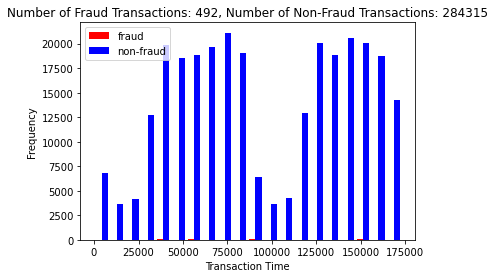

In [9]:
fraud = df['Class'] == 1
not_fraud = df['Class'] == 0

# Select the time values of fraud and non-fraud transactions
fraud_time = df.Time[fraud]
non_fraud_time = df.Time[not_fraud]

# Find the number of fraud and non-fraud transactions
num_fraud = len(fraud_time)
num_not_fraud = len(non_fraud_time)

# Create a histogram plot for fraud and non-fraud transactions
plt.hist([fraud_time, non_fraud_time], bins = 20, color = ['r', 'b'], label = ['fraud', 'non-fraud'])
plt.xlabel('Transaction Time')
plt.ylabel('Frequency')
plt.legend()
plt.title("Number of Fraud Transactions: {}, Number of Non-Fraud Transactions: {}".format(num_fraud, num_not_fraud))
plt.show()

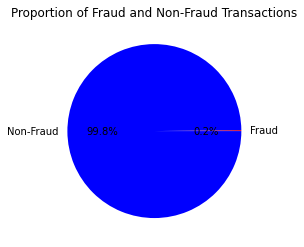

In [10]:
# Create a pie chart
labels = ['Fraud', 'Non-Fraud']
sizes = [num_fraud, num_not_fraud]
colors = ['r', 'b']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Proportion of Fraud and Non-Fraud Transactions")
plt.show()

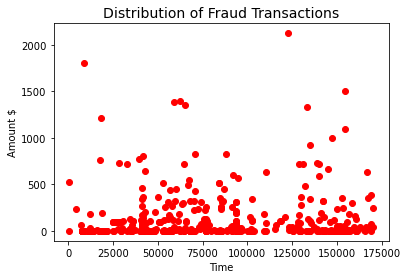

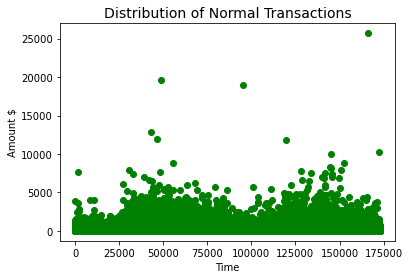

In [11]:
# Distribution of Fraud and Non-Fraud Transactions
plt.scatter(df.Time[df.Class == 1], df.Amount[df.Class == 1], color='red')
plt.title('Distribution of Fraud Transactions', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Amount $')
plt.show()

plt.scatter(df.Time[df.Class == 0], df.Amount[df.Class == 0], color='green')
plt.title('Distribution of Normal Transactions', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Amount $')
plt.show()

In [12]:
# Creating new dataframe
cleaned_df = df.copy()

# Deleting Time Column
cleaned_df.pop('Time')

# Converting Amount column to log-space.
eps = 0.001 
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

In [13]:
# Spliting and shuffling df
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [14]:
# Transforming and scaling the features for a machine learning model.
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [16]:
# Using SMOTE oversampling to the training features and labels
sm = SMOTE(sampling_strategy='minority', random_state=42)
train_features, train_labels = sm.fit_resample(train_features, train_labels)

In [18]:
# Print class counts in the oversampled dataset
print(Counter(train_labels))

Counter({0: 181965, 1: 181965})


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


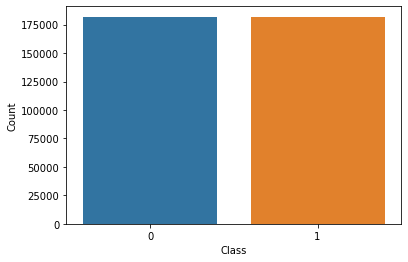

In [19]:
# Create a bar plot of class counts in the oversampled dataset
sns.countplot(train_labels)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [20]:
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (363930,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (363930, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [23]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

2023-01-29 19:57:45.499167: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [25]:
EPOCHS = 100
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [26]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.predict(train_features[:10])

2023-01-29 19:58:18.957738: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([[0.8790929 ],
       [0.770908  ],
       [0.8072798 ],
       [0.5151641 ],
       [0.79187924],
       [0.8184614 ],
       [0.8314359 ],
       [0.95699394],
       [0.99207175],
       [0.88990855]], dtype=float32)

In [28]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7907


In [29]:
model = make_model()

baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
356/356 [==============================] - 5s 7ms/step - loss: 0.3879 - tp: 316312.0000 - fp: 177694.0000 - tn: 186236.0000 - fn: 47618.0000 - accuracy: 0.6904 - precision: 0.6403 - recall: 0.8692 - auc: 0.8656 - prc: 0.9030 - val_loss: 0.1514 - val_tp: 71.0000 - val_fp: 548.0000 - val_tn: 44942.0000 - val_fn: 8.0000 - val_accuracy: 0.9878 - val_precision: 0.1147 - val_recall: 0.8987 - val_auc: 0.9754 - val_prc: 0.7909
Epoch 2/100
356/356 [==============================] - 1s 4ms/step - loss: 0.1807 - tp: 160299.0000 - fp: 4787.0000 - tn: 177178.0000 - fn: 21666.0000 - accuracy: 0.9273 - precision: 0.9710 - recall: 0.8809 - auc: 0.9791 - prc: 0.9826 - val_loss: 0.1044 - val_tp: 72.0000 - val_fp: 685.0000 - val_tn: 44805.0000 - val_fn: 7.0000 - val_accuracy: 0.9848 - val_precision: 0.0951 - val_recall: 0.9114 - val_auc: 0.9818 - val_prc: 0.7813
Epoch 3/100
356/356 [==============================] - 1s 4ms/step - loss: 0.1500 - tp: 163673.0000 - fp: 4507.0000 - tn: 177458.000

In [30]:
def plot_metrics(history, metrics=None, colors=None):
  if metrics is None:
    metrics = ['loss', 'prc', 'precision', 'recall']
  if colors is None:
    colors = ['red', 'blue', 'green', 'purple']

  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[n], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[n], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

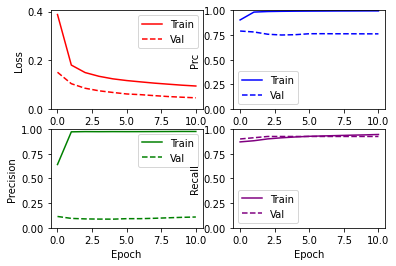

In [32]:
plot_metrics(baseline_history)

In [33]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.15396490693092346
tp :  87.0
fp :  710.0
tn :  56150.0
fn :  15.0
accuracy :  0.9872722029685974
precision :  0.10915935039520264
recall :  0.8529411554336548
auc :  0.9648048877716064
prc :  0.6919741630554199

Legitimate Transactions Detected (True Negatives):  56150
Legitimate Transactions Incorrectly Detected (False Positives):  710
Fraudulent Transactions Missed (False Negatives):  15
Fraudulent Transactions Detected (True Positives):  87
Total Fraudulent Transactions:  102


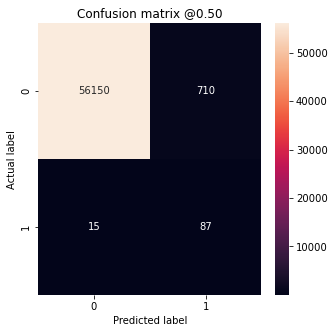

In [34]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)